# TP 2 : Computer Vision

## Part 1 : segmentation

In this part of the TP, we are going to implement two approaches to image segmentation :

- algorithm of Otsu (histogram-based segmentation)
- a simple region-growing based algorithm

First, let us load some packages and define some helper functions (as in the previous TP)

--2021-12-09 19:31:18--  https://perso.telecom-paristech.fr/anewson/doc/images/crossing.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638741 (624K) [image/png]
Saving to: ‘crossing.png’

crossing.png        100%[===================>] 623.77K  1.68MB/s    in 0.4s    

2021-12-09 19:31:19 (1.68 MB/s) - ‘crossing.png’ saved [638741/638741]



(800, 586)

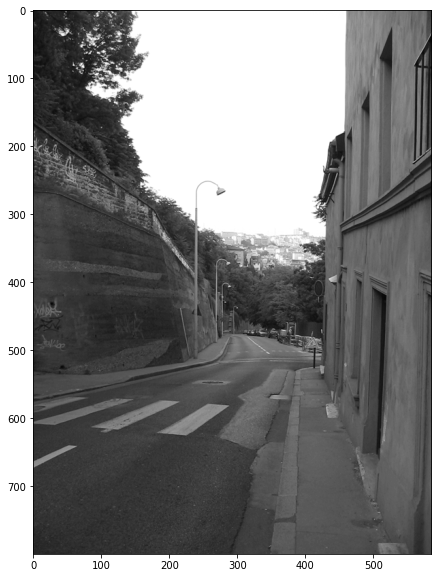

In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color

is_colab = True

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

file_dir = 'images/'
file_name = 'crossing'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/crossing.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

## Otsu's algorithm

Otsu's method is based on finding a threshold to split the image into two separate segments, based simply on their grey-level values. Since the maximum number of grey-levels is finite (and small: 256), we can use an exhaustive search.

The grey-level threshold is the one that minimises the following criterion :

$argmin_{\tau} \: \omega_0(\tau)\sigma_0(\tau) + \omega_1(\tau)\sigma_1(t)$

where

- $\sigma_0(\tau)$ and $\sigma_1(\tau)$ are the variances of the pixels in the first and second regions
- $\omega_0(\tau)$ and $\omega_1(\tau)$ are weights of the first and second regions

and 

- $\omega_0(\tau) = \sum_{p \in \Omega} \mathbb{1}_{\tau}(I(p)), \qquad$
- $\omega_1(\tau) = \sum_{p \in \Omega} 1-\mathbb{1}_{\tau}(I(p))$

and 

$\mathbb{1}_{\tau}(I(p)) =\begin{cases}
        1 \; \text{if} \: I(p)<=\tau\\
        0 \; \text{otherwise}
\end{cases}$

Implement this algorithm in a function called ``segmentation_otsu``. Note : only analyse thresholds which produce two distinct regions. Furthemore, remember that the image is normalised between 0 and 1, with 256 discrete values. Choose the threshold values accordingly.

In [2]:
def segmentation_otsu(img):
    n,m=img.shape
    taux=np.linspace(0,1,256)
    F=[]
    for tau in taux:
      v0,v1=[],[]
      w0,w1=0,0

      R0=img[img<=tau]
      R1=img[img>tau]

      w0=len(R0)
      w1=len(R1)

      if w0==0:
        F.append(w1*np.var(R1))
      elif w1==0:
        F.append(w0*np.var(R0))
      else:
        F.append(w1*np.var(R1)+w0*np.var(R0))

    
    tau_out=taux[F.index(min(F))]

    img_out=np.zeros((n,m))
    for i in range(n):
      for j in range(m):
        if img[i,j]>=tau_out:
          img_out[i,j]=1
    # TO FILL IN
    # RETURN BOTH THE SEGMENTED IMAGE AND THE THRESHOLD WHICH YOU HAVE FOUND
    return img_out,tau_out

Carry out the segmentation on the input image and display the result

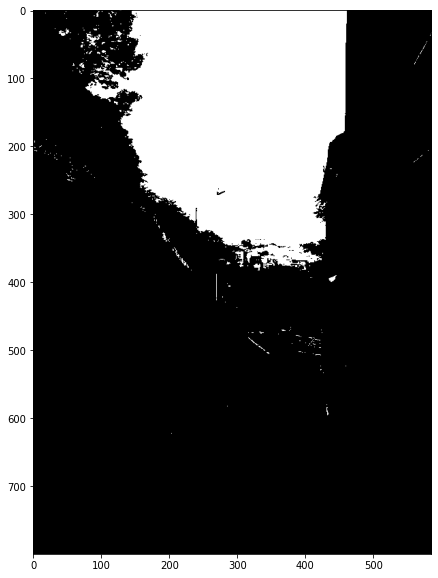

In [3]:
img_out_otsu,tau = segmentation_otsu(img_gray)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

In [4]:
tau

0.6392156862745098

__Question 1.1__ What problem can you see with the segmentation result ? What technique(s) (seen in the lesson) could you use to clean the result up ? 

__Answer__ 
We see that the boundary of the segmented regions is not well defined. In fact, there are noisy pixels inside the segmented regions as well as between them. In order to eliminate this problem, we can use morphological transformations such as opening and closing to clean the result.

Carry this out on the output image, and imwrite the result. You can find the necessary function(s) in the following package :

skimage.morphology

Choose the neighbourhood parameter of the functions to obtain the best results.

__Question 1.2__ In which order should you carry out the operations (you can test the different possibilities) ? Why ?

__Answer__ We should apply the opening at first and then carry out the closing. This enables the coverage of the noisy white pixels by the opening. And the closing will remove the eventual black pixels that may appear in the white region. Otherwise, if we begin by the closing, we will risk creating white new regions in the white noisy clusters. For example in the top left noisy region of the image we will have unwanted white regions if we don't apply the operations in the correct order.

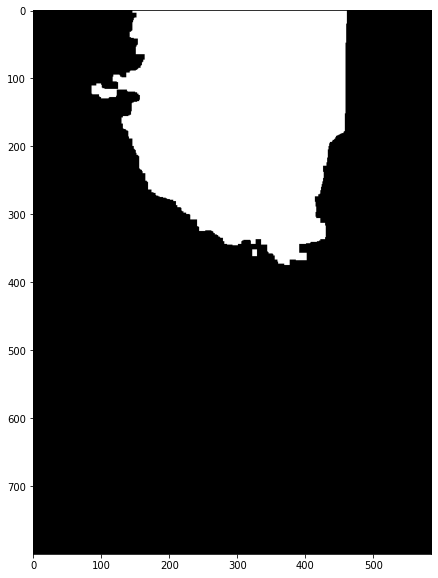

In [13]:
# FILL IN HERE
from skimage.morphology import opening,closing
struct_size = 7
struct_el = np.ones((struct_size,struct_size))
img_out_otsu_cleaned= opening(img_out_otsu,struct_el)
img_out_otsu_cleaned=closing(img_out_otsu_cleaned,struct_el)
display_image(img_out_otsu_cleaned)
write_image(img_out_otsu_cleaned,file_name+'_segmentation_otsu_cleaned_1.png')

Let's change the image, and carry out the segmentation again.

--2021-12-09 20:12:56--  https://perso.telecom-paristech.fr/anewson/doc/images/town.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 806256 (787K) [image/png]
Saving to: ‘town.png’

town.png            100%[===================>] 787.36K  1.71MB/s    in 0.4s    

2021-12-09 20:12:57 (1.71 MB/s) - ‘town.png’ saved [806256/806256]



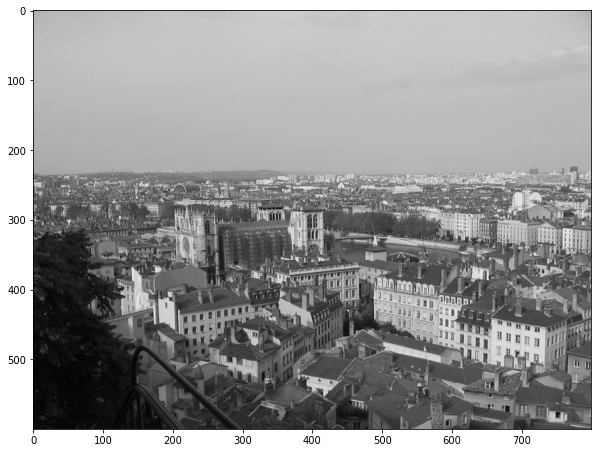

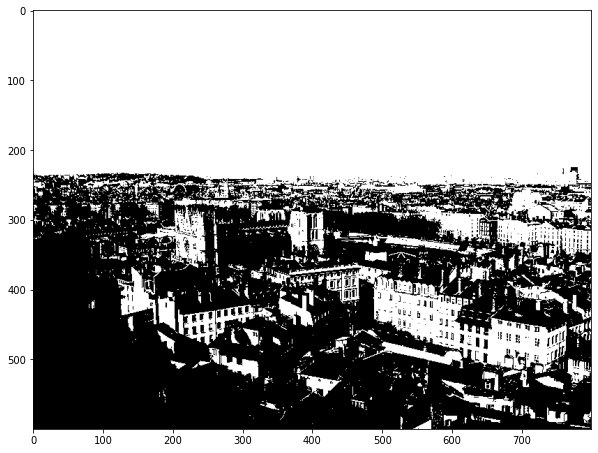

In [14]:
file_name = 'town'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/town.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

img_out_otsu,tau = segmentation_otsu(img_gray)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

As we can see, there is no notion of connectivity in the algorithm of Otsu (two regions far away can be in the same segment). For such a notion, we turn to region merging.

## Region merging

The region merging algorithm is quite simple : we start with a small region, and add pixels progressively to the region, according to a criterion. We choose the following criterion :

- $I(p)$ is added to the region if the absolute difference between the pixel value and the region's average value is less than a threshold value (which you must set).

First, create a function called ``initialize_segmentation`` which initialises the segmentation with a small circular region centred on a given seed point (the seed point is an input). For this, the following function :

- scipy.ndimage.morphology.distance_transform_edt

can be useful.

In [15]:
from scipy.ndimage.morphology import distance_transform_edt
def initialize_segmentation(seed_pt,img_shape):
    # FILL IN HERE
    n,m=img_shape
    F= np.ones(img_shape)
    F[seed_pt[0],seed_pt[1]] = 0
    f_inter = distance_transform_edt(F)
    seg_init =np.zeros(img_shape)
    seg_init[f_inter<5]=1
    return seg_init

Now, create a function called ``segmentation_region_growing`` which carries out the region growing algorithm, with the criterion above, and which uses the ``initialize_segmentation`` function. Again, the functions from ``scipy.ndimage.morphology`` can be useful here.

You will have to choose a neighbourhood that indicates which neighbouring pixels we want to try and include in the region. Use the following neighbourhood: $$ \begin{pmatrix} 0 & 1 & 0 \\ 1 & 1 & 1 \\ 0 & 1 & 0\end{pmatrix}$$

In [16]:
Structuring_element=np.array([[0,1,0],
                              [1,1,1],
                              [0,1,0]])

from scipy.ndimage import binary_dilation

def segmentation_region_growing(img,seed_pt,tau):
  img_result=img.copy()
  seg_init=initialize_segmentation(seed_pt,img.shape)
  I=seg_init.copy()
  Rx,Ry=np.where(I==1)
  Rx=list(Rx)
  Ry=list(Ry)
  img_result[Rx,Ry]=1
  while 1:
    µ=np.mean(img[Rx,Ry])
    V= np.abs(binary_dilation(I)-I)
    Vx,Vy=np.where(V==1)
    add=False
    for i in range(len(Vx)):
      if np.abs(img[Vx[i],Vy[i]]-µ)<tau:
        add=True
        Rx.append(Vx[i])
        Ry.append(Vy[i])
        I[Vx[i],Vy[i]]=1
        img_result[Vx[i],Vy[i]]=1
    if not add:
      break 
  # FILL IN HERE
  # RETURN BOTH THE SEGMENTED IMAGE AND THE INITIALISATION WHICH YOU FOUND
  seg_n=I#img_result
  return seg_n,seg_init

Carry out the segmentation on the input image with the seed point and threshold specified in the following code :

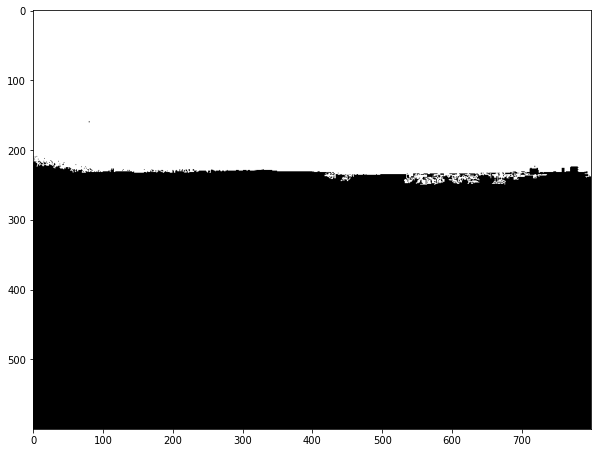

In [17]:
seed_pt = np.asarray([130,350])
tau = 20.0 * (1.0/256.0)
img_out_region_growing,seg_init = segmentation_region_growing(img_gray,seed_pt,tau)
display_image(img_out_region_growing)
write_image(seg_init,file_name+'_segmentation_region_growing_init.png')
write_image(img_out_region_growing,file_name+'_segmentation_region_growing.png')

__Question 1.3__ What final problem, especially concering the boundary between the regions, can you see ? What method could be used instead of region growing, could solve this problem ?

__Answer__ We can see that the boundary between the two regions is not very smooth. In fact, the far away buildings with high intensity values in the image were associated with the sky region. This induced some noisy pixels on the boundary. We can use actrive contours method  that may give a better boundary between the regions.

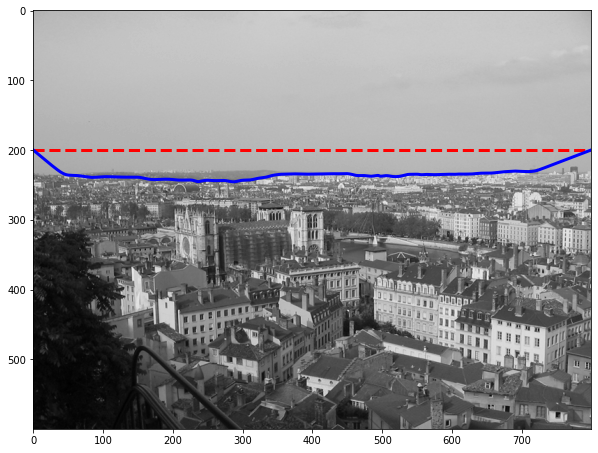

In [18]:
from skimage.segmentation import active_contour
from skimage.filters import gaussian
r=[200 for i in range(600)]
c=np.linspace(0,img_gray.shape[1]-1,600)
init = np.array([r, c]).T
snake = active_contour(gaussian(img_gray, 1, preserve_range=False),
                       init, boundary_condition='fixed',
                       alpha=1, beta=10, w_line=-5, w_edge=0, gamma=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_gray, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
#display_image(snake)